In [11]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [31]:
# import system_message.txt as a string
with open('prompts/system_message.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze earnings call transcripts of companies and extract specific textual features, sentiment scores, and key financial metrics. These features will be used to predict the recovery rate of bonds issued by these companies.

Objective:
Given the provided earnings call transcript, extract the following features, metrics, and scores, and format the final output exactly as specified below.

1. Sentiment Scores:
Evaluate the sentiment expressed throughout the earnings call using the following categories:

Negative Sentiment (0-1): Measures the extent of negative language (e.g., risks, losses, challenges). A score closer to 1 indicates a highly negative tone.
Positive Sentiment (0-1): Assesses the presence of positive language (e.g., growth, profits, opportunities). A higher score indicates optimism.
Uncertainty Sentiment (0-1): Captures language related to uncertainty (e.g., "uncertain," 

In [73]:
transcripts = pd.read_csv('transcripts/mapped_transcripts.csv', delimiter='|')

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(transcripts['Cleaned_Bankruptcy_Indicators'].nunique())

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['Cleaned_Bankruptcy_Indicators'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'Cleaned_Bankruptcy_Indicators']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

196


,transcript_number,Cleaned_Bankruptcy_Indicators
0,0,oper instruct would now like to turn the call ...
1,1,as remind this confer is be record today tuesd...
2,2,present oper greet ladi and gentlemen and welc...
3,3,with me today are dick bond our presid and ceo...
4,4,present oper thank you for join the silgan hol...


In [33]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

output = []
start = 0

In [59]:
counter = 0
for i in number_transcript['Cleaned_Bankruptcy_Indicators']:
    if counter == start:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": i}
            ]
        )
        output.append(completion.choices[0].message.content)
        print(len(output))
    else:
        counter += 1


159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


In [60]:
start = len(output)
print(start)

196


In [62]:
# in output replace N/A with -1
output = [i.replace('N/A', '-1') for i in output]

In [74]:
output_df = pd.DataFrame(columns=['negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
                                  'profitability', 'liquidity', 'leverage', 'operating', 'market', 'management',
                                  'sentiment', 'tone', 'forwardlooking', 'confidence',
                                  'icr', 'de', 'fcf', 'debt2ebitda', 'zscore'])

# split output into columns with regex and convert to float
output_df['negative'] = [float(i.split('; ')[0]) for i in output]
output_df['positive'] = [float(i.split('; ')[1]) for i in output]
output_df['uncertainty'] = [float(i.split('; ')[2]) for i in output]
output_df['litigious'] = [float(i.split('; ')[3]) for i in output]
output_df['strong'] = [float(i.split('; ')[4]) for i in output]
output_df['weak'] = [float(i.split('; ')[5]) for i in output]
output_df['profitability'] = [float(i.split('; ')[6]) for i in output]
output_df['liquidity'] = [float(i.split('; ')[7]) for i in output]
output_df['leverage'] = [float(i.split('; ')[8]) for i in output]
output_df['operating'] = [float(i.split('; ')[9]) for i in output]
output_df['market'] = [float(i.split('; ')[10]) for i in output]
output_df['management'] = [float(i.split('; ')[11]) for i in output]
output_df['sentiment'] = [float(i.split('; ')[12]) for i in output]
output_df['tone'] = [float(i.split('; ')[13]) for i in output]
output_df['forwardlooking'] = [float(i.split('; ')[14]) for i in output]
output_df['confidence'] = [float(i.split('; ')[15]) for i in output]
output_df['icr'] = [float(i.split('; ')[16]) for i in output]
output_df['de'] = [float(i.split('; ')[17]) for i in output]
output_df['fcf'] = [float(i.split('; ')[18]) for i in output]
output_df['debt2ebitda'] = [float(i.split('; ')[19]) for i in output]
output_df['zscore'] = [float(i.split('; ')[20]) for i in output]

output_df

,negative,positive,uncertainty,litigious,strong,weak,profitability,liquidity,leverage,operating,...,management,sentiment,tone,forwardlooking,confidence,icr,de,fcf,debt2ebitda,zscore
0,0.60,0.40,0.30,0.05,0.85,0.25,0.60,0.80,0.45,0.20,...,0.60,0.30,0.70,0.65,0.75,0.80,4.0,2.0,0.5,3.0
1,0.30,0.55,0.45,0.05,0.70,0.60,0.45,0.80,0.50,0.30,...,0.55,0.70,0.85,0.60,0.75,0.80,3.0,4.0,0.0,3.0
2,0.40,0.50,0.30,0.10,0.60,0.25,0.15,0.70,0.50,0.20,...,0.45,0.55,0.75,0.60,0.80,0.75,3.0,4.0,0.0,3.0
3,0.35,0.55,0.70,0.10,0.60,0.40,0.75,0.80,0.50,0.20,...,0.30,0.70,0.75,0.65,0.85,0.90,3.0,4.0,1.0,4.0
4,0.45,0.65,0.55,0.10,0.75,0.35,0.60,0.80,0.70,0.30,...,0.50,0.80,0.85,0.75,0.65,0.70,4.0,2.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.65,0.35,0.55,0.15,0.60,0.40,0.70,0.65,0.55,0.45,...,0.30,0.60,0.75,0.50,0.70,0.85,3.0,4.0,0.0,3.0
192,0.25,0.65,0.45,0.10,0.80,0.50,0.70,0.80,0.60,0.40,...,0.55,0.90,0.85,0.70,0.75,0.80,4.0,3.0,1.0,2.0
193,0.20,0.75,0.30,0.05,0.85,0.15,0.85,0.80,0.70,0.20,...,0.65,0.60,0.80,0.75,0.85,0.90,4.0,1.0,0.0,3.0
194,0.60,0.20,0.40,0.10,0.50,0.70,0.45,0.30,0.55,0.20,...,0.30,0.60,0.25,0.50,0.40,0.30,3.0,4.0,0.0,2.0


In [75]:
output_df['transcript_number'] = output_df.index

# merge output_df with transcripts on 'transcript_number' and index
transcripts = pd.merge(transcripts,
                          output_df,
                          on='transcript_number',
                          how='left')

# drop all rows where 'negative' is NaN
transcripts = transcripts.dropna(subset=['negative'])

checkpoint = transcripts.copy()

In [2]:
# save checkpoint as csv
#checkpoint.to_csv('transcripts/LLM_outputs.csv', index=False)
checkpoint = pd.read_csv('transcripts/LLM_outputs.csv')

In [24]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

llm_labels = ['negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
                                  'profitability', 'liquidity', 'leverage', 'operating', 'market', 'management',
                                  'sentiment', 'tone', 'forwardlooking', 'confidence',
                                  'icr', 'de', 'fcf', 'debt2ebitda', 'zscore']

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    + supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [25]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     54.78
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          1.84e-233
Time:                        10:09:07   Log-Likelihood:                -4382.5
No. Observations:                1075   AIC:                             8853.
Df Residuals:                    1031   BIC:                             9072.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

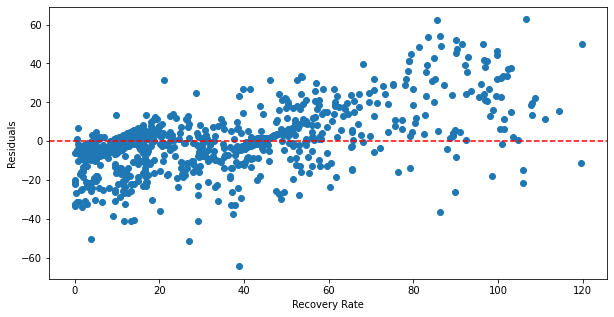

In [26]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [27]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3894.001350
24                                  positive    18.858756
17                                Financials    18.125833
23                                  negative    14.843413
11                      ActIndustryDistress1     9.854623
36                                      tone     9.562710
2                    NASDAQ 100 Index return     9.295052
34                                management     8.581303
4         30 year conventional mortgage rate     7.688953
3   Manufacturers inventories to sales ratio     7.473286
1                 CBOE DJIA Volatility Index     6.405213
28                                      weak     6.393780
38                                confidence     6.000570
27                                    strong     5.751832
18                                    Energy     5.324887
37                            forwardlooking     4.996605
41            

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     54.78
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          1.84e-233
Time:                        10:08:34   Log-Likelihood:                -4382.5
No. Observations:                1075   AIC:                             8853.
Df Residuals:                    1031   BIC:                             9072.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

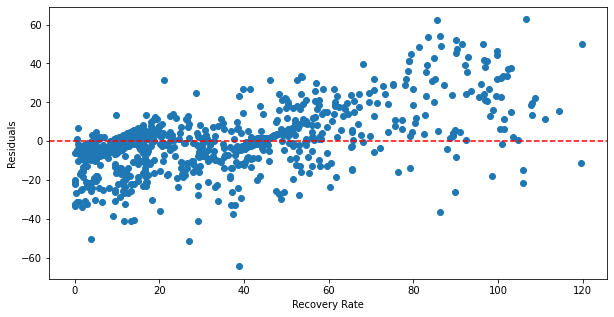

In [22]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [23]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3894.001350
24                                  positive    18.858756
17                                Financials    18.125833
23                                  negative    14.843413
11                      ActIndustryDistress1     9.854623
36                                      tone     9.562710
2                    NASDAQ 100 Index return     9.295052
34                                management     8.581303
4         30 year conventional mortgage rate     7.688953
3   Manufacturers inventories to sales ratio     7.473286
1                 CBOE DJIA Volatility Index     6.405213
28                                      weak     6.393780
38                                confidence     6.000570
27                                    strong     5.751832
18                                    Energy     5.324887
37                            forwardlooking     4.996605
41            